#Problema de regresion basico
$$
\Large y = b + w x + \epsilon
$$

## Datos Sinteticos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
%matplotlib inline
import torch
import torch.optim as optim
import torch.nn as nn

In [ ]:
true_b = 15
true_w = 3.5
N = 1000

# Generacion de datos, fijamos una semilla
np.random.seed(100)
#Generamos un arreglo con elementos aleatorios
x = np.random.rand(N, 1)
#Generamos un arreglo con errores aleatorios
epsilon = (.1 * np.random.randn(N, 1))

#Calculamos un conjunto de datos con lo anteriormente creado
y = true_b + true_w * x + epsilon

## Separamos en conjuntos de Entrenamiento y Prueba

In [ ]:
from sklearn.model_selection import train_test_split

X_train,X_val, y_train,  y_val=train_test_split(x, y, train_size=0.8, random_state=100)

## Solucion Sckit-Learn

In [ ]:
linr = LinearRegression()
linr.fit(X_train, y_train)
print(linr.intercept_, linr.coef_[0])

[15.01090749] [3.48212954]


In [ ]:
b_minimum, w_minimum = linr.intercept_[0], linr.coef_[0]
# Creamos un rango de valores para graficar
x_range = np.linspace(0, 1, 101)
# Utilizamos los estimadores para crear una estimacion de los valores en el rango
yhat_range = b_minimum + w_minimum * x_range

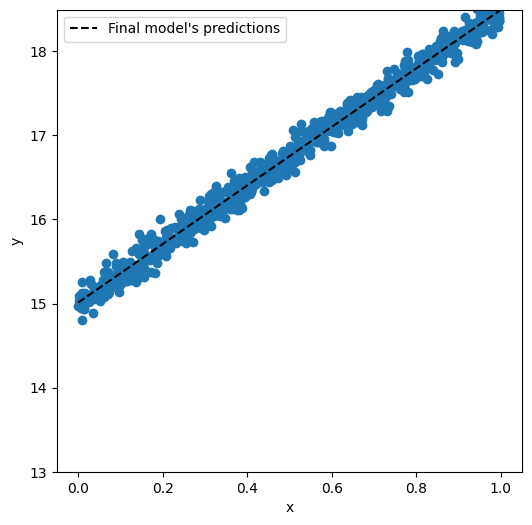

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_ylim([13, np.max(yhat_range)])
# Un grafico de dispersion de los datos de entrenamiento
ax.scatter(X_train, y_train)
# Graficamos una linea con los datos del modelo estimado
ax.plot(x_range, yhat_range, label='Final model\'s predictions', c='k', linestyle='--')
ax.legend(loc=0)

**Scikit-Learn provee una solucion bastante rapido y parece adecuarde a la realidad de los datos sinteticos**

# PyTorch

In [ ]:
#Fijamos el uso de GPU para entrenamiento
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


**Creamos los tensores que utilizaremos para el entrenamiento**

In [ ]:
X_train_tensor = torch.as_tensor(X_train).float().to(device)
y_train_tensor = torch.as_tensor(y_train).float().to(device)

In [ ]:
X_val_tensor = torch.as_tensor(X_val).float().to(device)
y_val_tensor = torch.as_tensor(y_val).float().to(device)

##Modelo

Hay varias formas en que se pueden aprender los parametros $\beta$ y $W$ que se buscan

### Como parametro

In [ ]:
class ManualLinearRegression(nn.Module):
    def __init__(self):
        #Podemos directamente decirle a Pytorch que buscamos aprender un conjunto de parametros
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.w = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, x):
        #Evaluacion del modelo
        return self.b + self.w * x

model=ManualLinearRegression()

### Capas lineales

In [ ]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        ## Pytroch cuenta con nn.Linear que es una capa lineal
        ## En nuestro caso necesitamos un solo input y un solo output
        ## Pytorch sabe que tiene que entrenar un w de pesos y un beta de sesgo (bias)
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        # Solo evalua la capa lineal
        self.linear(x)

model=LayerLinearRegression()

### Como secuencia

In [ ]:
torch.manual_seed(100)
# Puedes agregar el numero de funcionales de Pytorch que quieras en secuencia
model = nn.Sequential(nn.Linear(1, 1)).to(device)

##Funcion de entrenamiento

In [ ]:
def make_train_step(model, loss_fn, optimizer):
    # Fija el modelo, la funcion de perdida y optimizador, ayudando al proceso
    def train_step(x, y):
        # Pone el modelo en modo entrenamiento
        model.train()
        # Evalua el tensor en el modelo
        yhat = model(x)
        # Calcula la perdida, respecto al valor real
        loss = loss_fn(y, yhat)
        # Calcula los gradientes
        loss.backward()
        # Actualiza los valores de los parametros
        optimizer.step()
        # Reinicia la cuenta de los gradientes
        optimizer.zero_grad()
        # Regresamos la perdida para llevar registro
        return loss.item()

    # # Fija el modelo, la funcion de perdida y optimizador, ayudando al proceso
    return train_step

In [ ]:
from torch.utils.data import  TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

#Creamos un objeto iterable a partir de los tensores
train_data = TensorDataset(X_train_tensor, y_train_tensor)
print(X_train_tensor.shape, y_train_tensor.shape)

val_data=TensorDataset(X_val_tensor, y_val_tensor)
print(X_val_tensor.shape, y_val_tensor.shape)

torch.Size([800, 1]) torch.Size([800, 1])
torch.Size([200, 1]) torch.Size([200, 1])


## Entrenamiento

In [ ]:
torch.manual_seed(42)

#Vaciamos los TensorDataset iterables en un Dataloader, este pasa 'rebanadas' de nuestros datos
train_loader = DataLoader(dataset=train_data, batch_size=16)
val_loader = DataLoader(dataset=val_data, batch_size=20)

# Utilizaremos la version Sequential del modelo lineal, pero es equivalente a los anteriores
model = nn.Sequential(nn.Linear(1, 1)).to(device)
print(model.state_dict())

# Fijamos parametros del entrenamiento
lr = 1e-1
n_epochs = 100

# Utilizaremos MSE como funcion de perdida
loss_fn = nn.MSELoss(reduction='mean')
# Utilizaremos SGD como optimizador
optimizer = optim.SGD(model.parameters(), lr=lr)

#Creamos una lista para llevar el track de las perdidas
losses = []
val_losses = []
# Fijamos la funcion con el modelo, funcion de perdida y optimizador
train_step = make_train_step(model, loss_fn, optimizer)


for epoch in range(n_epochs):
    # En cada epoca, reocrremos cada elemento en el dataloader
    for x_batch, y_batch in train_loader:
        #Enviamos los tensores al device, para no sobrecargar la memoria
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        # Obtenemos la perdida aplicando la funcion de entrenamiento
        loss = train_step(x_batch, y_batch)
        losses.append(loss)



    #No queremos modificar los gradientes
    with torch.no_grad():
        # Recorremos cada tensor en el dataloader
        for x_val, y_val in val_loader:
            #Enviamos los conjuntos al dispositivos
            x_val = x_val.to(device)
            y_val = y_val.to(device)

            # Ponemos el modelo en modo EVALUACION, evitando modificar los gradientes
            model.eval()
            # Generamos la prediccion
            yhat = model(x_val)
            # Calculamos la perdida en el cojunto de validaciion
            val_loss = loss_fn(y_val, yhat)
            val_losses.append(val_loss.item())
    print(f"[{epoch+1}] Training loss: {loss:.3f}\t Validation loss: {val_loss:.3f}")

Observe los resultados de los parametros entrenados en model.state_dict()

In [ ]:
print(model.state_dict())
print('mean training loss:', np.mean(losses))
print('mean validation loss:', np.mean(val_losses))

OrderedDict([('0.weight', tensor([[3.4875]], device='cuda:0')), ('0.bias', tensor([15.0273], device='cuda:0'))])
mean training loss: 0.12895739068901166
mean validation loss: 0.014901133072096855


Bastante cercano al 3 y 15 que son los valores reales.

In [ ]:
print(model.state_dict()['0.weight'])
print(model.state_dict()['0.bias'])

tensor([[3.4875]], device='cuda:0')
tensor([15.0273], device='cuda:0')


##Grafica

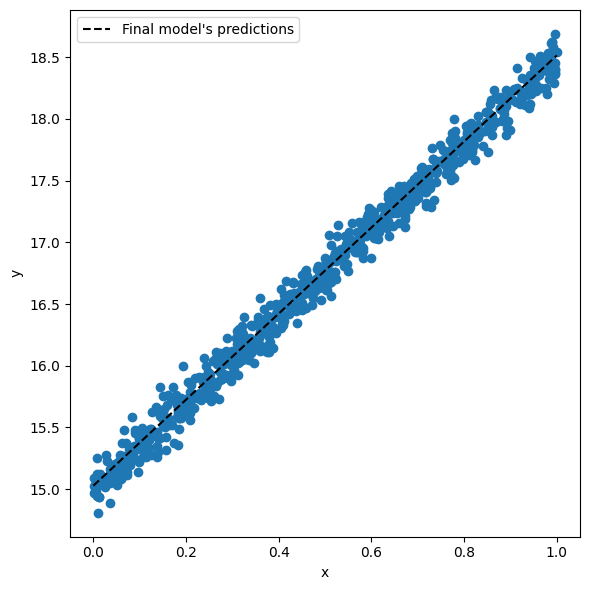

In [ ]:
b_minimum, w_minimum = model.state_dict()['0.bias'].cpu().detach().numpy()[0], model.state_dict()['0.weight'].cpu().detach().numpy()[0]
# Creamos rango de valores
x_range = np.linspace(0, 1, 101)
# Calculamos las estimaciones usando los estimadores
yhat_range = b_minimum + w_minimum * x_range

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.set_xlabel('x')
ax.set_ylabel('y')

# Grafico de dispersion del conjunto de entrenamiento
ax.scatter(X_train, y_train)
# Graficamos las predicciones
ax.plot(x_range, yhat_range, label='Final model\'s predictions', c='k', linestyle='--')
ax.legend(loc=0)
fig.tight_layout()